In [5]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
from scipy.fft import fftn, ifftn,fftshift
from ter_coder import *
ter = ter()
ter.check_options()

-->  ...............................................
-->  Available options:    [default values]
-->  ···············································
-->  TER_coder_sw_path:     TER_iaa_coder.jar
-->  TER_decoder_sw_path:   TER_iaa_decoder.jar
-->  input_folder_path:     ./
-->  code_ext:              .rec
-->  imageName_input:       inputImage
-->  imageName_output_coded:  outputImage_coded
-->  imageName_output_decoded:  outputImage_decoded
-->  image_width:           2048
-->  image_height:          2048
-->  endianess:             b
-->  target_bpp:            0
-->  dc_stop:               0
-->  bitplaneStop:          0
-->  stage_stop:            4
-->  output_folder_path:    ./
-->  decode_ext:            .raw
-->  scale_value:           (0, 0)
-->  io_format:             <i2
-->  _signedPixels:         1
-->  verbose:               1
-->  ···············································


In [3]:
#get data
file = 'solo_L2_phi-fdt-blos_20220308T070009_Vreview_2D_0243080501.fits.gz'
with fits.open(file) as hdul:
    data = hdul[0].data

In [12]:
def rebin_fft(data,n):
    yd,xd = data.shape
    ift = fftshift(fftn(data))
    return np.real(ifftn(fftshift(ift[yd//2 - yd//n//2:yd//2 + yd//n//2,xd//2 - xd//n//2:xd//2 + xd//n//2])))/2/n

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

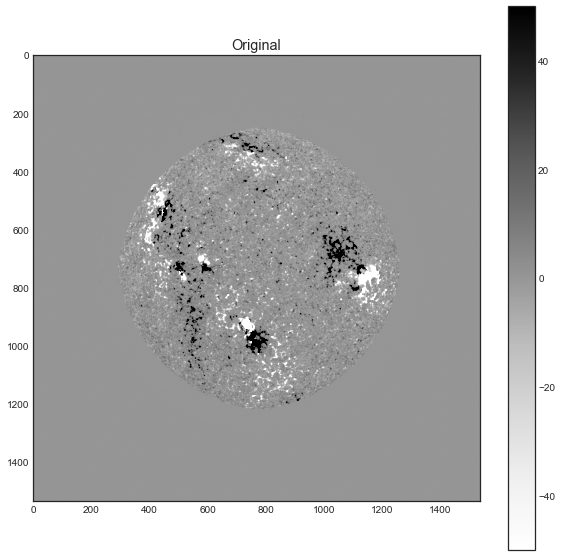

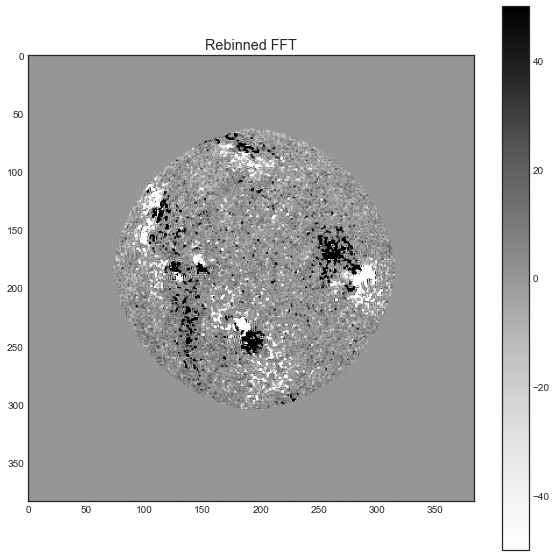

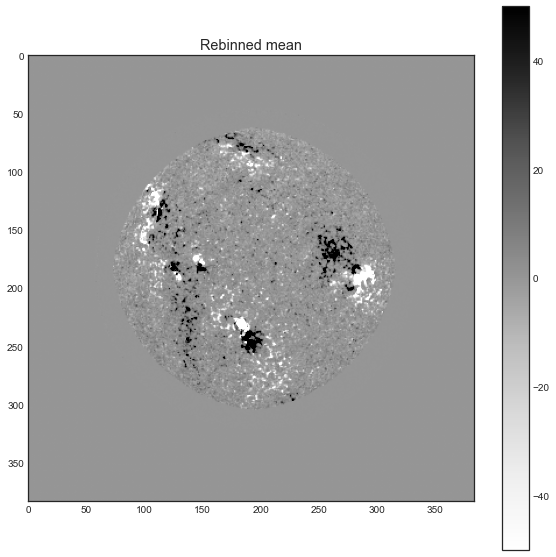

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(data,clim=(-50,50))
plt.title('Original')
plt.colorbar()
plt.show()

n = 4   #reduce by factor n
yd,xd = data.shape

data_fft_binned = rebin_fft(data,n)
plt.figure(figsize=(10,10))
plt.imshow(data_fft_binned,clim=(-50,50))
plt.title('Rebinned FFT')
plt.colorbar()
plt.show()

data_mean_binned = rebin(data,[xd//n,yd//n])
plt.figure(figsize=(10,10))
plt.imshow(data_mean_binned,clim=(-50,50))
plt.title('Rebinned mean')
plt.colorbar()
plt.show()

In [14]:
#compression SET UP 
ter.signedPixels = 1
ter.image_height = b.shape[0]
ter.image_width = b.shape[1]
bpp = 6

-->  setting i/o:  >i2


In [17]:
test_data = data_mean_binned
ter.save_raw(test_data)
ter.code()
ter.decode()
out_data = ter.read_output()

-->  saving... ./inputImage.raw
-->  >i2
-->  java -jar TER_iaa_coder.jar -i ./inputImage.raw -cl 1 -bs 48 -dc 0 -bp 0 -ss 4 -g 1 384 384 3 0 0 -o ./outputImage_coded
-->  In this case all values should be represented in one single bit.!!
In this case all values should be represented in one single bit.!!

-->  java -jar TER_iaa_decoder.jar -i ./outputImage_coded.rec -g 1 384 384 3 0 0 -o ./outputImage_decoded.raw
-->  
-->  reading...  ./outputImage_decoded.raw


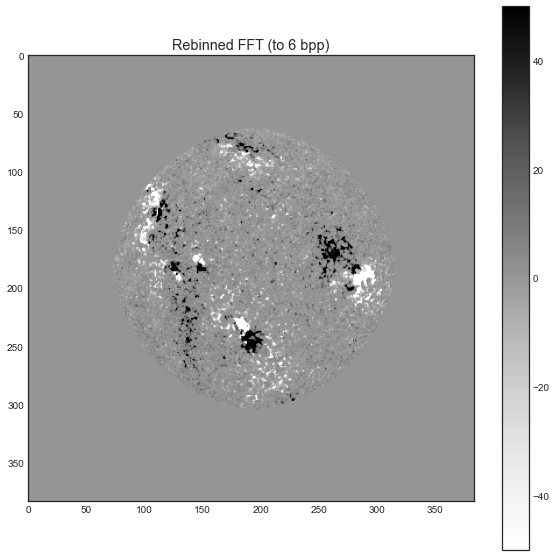

In [18]:
plt.figure(figsize=(10,10))
plt.title('Rebinned FFT (to 6 bpp)')
plt.imshow(out_data,clim=(-50,50))
plt.colorbar()
plt.show()